## Start measurments

In [1]:
#%matplotlib notebook
import os, time, sys
import importlib
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import panda2.panda2 as panda2

import panda2.analysis.fitfunctions as fitfunc
import panda2.scans.injection_scan as injection_scan


# run "ping" command
!ping -c 1 192.168.10.16

# instancíate a Panda2 class
dut = panda2.Panda2()
# read yaml file and connect to FPGA
dut.init()
dut.set_sync(auto_sync=True)  ## do not delete this


PING 192.168.10.16 (192.168.10.16) 56(84) bytes of data.
64 bytes from 192.168.10.16: icmp_seq=1 ttl=64 time=0.125 ms

--- 192.168.10.16 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.125/0.125/0.125/0.000 ms


2024-07-04 16:58:14,713 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing spi_inj (firmware version: 2), module basil.HL.spi, base_addr 0x10
2024-07-04 16:58:14,715 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing inj (firmware version: 1), module panda2.pulse_gen_div, base_addr 0x100
2024-07-04 16:58:14,716 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing sync (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x140
2024-07-04 16:58:14,718 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gate (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x180
2024-07-04 16:58:14,719 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing ts_inj (firmware version: 1), module panda2.timestamp_div, base_addr 0x1c0
2024-07-04 16:58:14,721 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gpio (firmware version: 0), module basil.HL.gpio, base_addr 0x200
20

In [6]:
en_comp_org = np.array([np.copy(dut.PixelConf['en_comp0']), 
                        np.copy(dut.PixelConf['en_comp1'])])
en_comp_org[1,1,1]=1
en_comp_org[0,2,3]=1
np.argwhere(en_comp_org==1)[:,2]


array([3, 1])

## Change settings (global, tdac, comp_en/dis etc)

### global configurations

In [7]:
# define col, row
col, row = 15, 2
### configure chip and enable injection
dut.set_en_inj([col, row])

# this is for Injection card
dut.set_inj_amp(0.05)

# set ampout ON
dut.set_en_ampout([col])
#dut.set_en_ampout([])


### inj_n: number of pulses to be injected. 0=continuous injection
# 1 = 1 clock of 40MHz = 25ns  inj_n= number of pulses to be injected, 0= inf
dut.set_inj(inj_n=1, inj_width=1024*8, inj_delay=1024*8, ext=True)
dut.inject()

#hui
## set all tdac to 0
#dut.set_tdac(7, comp='fast')
### slow comp
tdac1 = np.copy(dut.PixelConf['tdac1'])
#tdac1[:, :] = 7    # until 7
#dut.set_tdac(tdac1, comp='slow')
VDACTh2=150 # 120v 165 176 used for tune (176 tuned scan) 166 later used 163 for 50v hv
#VDACTh2=250#150+26

##fast comp
tdac0 = np.copy(dut.PixelConf['tdac0'])
tdac0[:, :] = 7   # until 7
#dut.set_tdac(tdac0, comp='fast')
#VDACTh=250
VDACTh=150 #120v 179 ivan 195 (192 for tune all!!!, tuned scan 190) used for tune! 182 later user 178 for 50V hv

# sets VDAC and DAC
dut.set_conf(
             IPBigFine= 15,
             IPSmallFine= 23,
             VDACTh=VDACTh,  # fast comparator, 255= very high (alomost off)
             VDACTh2=VDACTh2, # slow comparator, ~128 =  a bit higher than VDACBL 
             VDACBL=102+26,  # base line ~100~128 
             VNComp=40, # default =40
             VNComp2=0,
             VN=32, 
             INFoll2=20,
             VNFoll=4, # std setting 2
             IPLoad2=4,#std setting 2
             hidrEnB=1,   #1 disalbe, 0 enalbe
             IBLRes=1,    # R of Bl
             IPDAC=50,   #50
             VNLVDS = 20,
             VNLVDSDel = 0,
             Invert = 1,
             VPDcl = 32,
             VNDcl = 32,
             IPFoll=10, # current for Ampout and HitBus defalt=10, OFF=0 (better for cross talk) 
                        # TDAC=7 no offset, TDAC=0 max negative offset
            )  ## set lowest (largest in number) threshold
            # IPDAC until 63
# sets comparator 
en_comp = np.copy(dut.PixelConf['en_comp0'])
### set all comp off
en_comp[:,:] = 1
en_comp[:,0] = 0
dut.set_en_comp(en_comp, comp='slow')
dut.set_en_comp(en_comp, comp='fast')
### set comp1 col=10, row=0 ON
en_comp[col, row] = 1
#hui
dut.set_en_comp(en_comp, comp='slow')
dut.set_en_comp(en_comp, comp='fast')
                #comp='slow')  ## 0= fast comp, 1 = slow

dut.set_en_hitbus([])

# set_sync: set SyncRes
dut.set_sync(auto_sync=True)


# set timestamp module ON
dut.set_ts_inj(True)

# set the data reciever ON
dut.set_rx(True)
# but mask data for this moment
dut['data_rx'].SAMPLING_EDGE=0
dut.mask_rx(True)


2024-07-04 17:10:37,194 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00008000 en_injection_row0=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000 en_injection_row1=00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00000_00001
2024-07-04 17:10:37,196 - root - [INFO    ] (MainThread) inj_amp: 257
2024-07-04 17:10:37,201 - root - [INFO    ] (MainThread) set_en_ampout: en_ampout_col=0x00008000
2024-07-04 17:10:37,208 - root - [INFO    ] (MainThread) set_inj: inj_width=8192 inj_delay=8192 inj_phase=-1 inj_n=1 ext=1
2024-07-04 17:10:37,213 - root - [INFO    ] (MainThread) set_conf:IPBigFine=15IPSmallFine=23VDACTh=150VDACTh2=150VDACBL=128VNComp=40VNComp2=0VN=32INFoll2=20VNFoll=4IPLoad2=4hidrEnB=1IBLRes=1IPDAC=50VNLVDS=20VNLVDSDel=0Invert=1VPDcl=32VNDcl=32IPFoll=10
2024-07-04 17:10:37,222 - root - [INFO    ] (MainThread) _write_conf row1 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[7 7

++++++++++++++comp fast++++++++++++++ []
++++++++++++++comp slow++++++++++++++ []
++++++++++++++comp fast++++++++++++++ []
++++++++++++++comp slow++++++++++++++ []
++++++++++++++comp fast++++++++++++++ []
++++++++++++++comp slow++++++++++++++ []
++++++++++++++comp fast++++++++++++++ []
++++++++++++++comp slow++++++++++++++ []
++++++++++++++comp fast++++++++++++++ []
++++++++++++++comp slow++++++++++++++ [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61]


2024-07-04 17:10:37,396 - root - [INFO    ] (MainThread) _write_conf row22 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-04 17:10:37,405 - root - [INFO    ] (MainThread) _write_conf row23 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-04 17:10:37,414 - root - [INFO    ] (MainThread) _write_conf row24 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-04 17:10:37,421 - root - [INFO    ] (MainThread) _write_conf row25 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-04 17:10:37,429 - root - [INFO    ] (MainThread) _write_conf row26 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[7 7 7 7 7 7 7 7 7 7

++++++++++++++comp fast++++++++++++++ [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61]


2024-07-04 17:10:37,952 - root - [INFO    ] (MainThread) _write_conf row24 en_comp[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-04 17:10:37,960 - root - [INFO    ] (MainThread) _write_conf row25 en_comp[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-04 17:10:37,969 - root - [INFO    ] (MainThread) _write_conf row26 en_comp[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-04 17:10:37,978 - root - [INFO    ] (MainThread) _write_conf row27 en_comp[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-07-04 17:10:37,986 - root - [INFO    ] (MainThread) _write_conf row28 en_comp[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7

++++++++++++++comp slow++++++++++++++ []
++++++++++++++comp fast++++++++++++++ []
++++++++++++++comp slow++++++++++++++ []
++++++++++++++comp fast++++++++++++++ []
++++++++++++++comp slow++++++++++++++ []
++++++++++++++comp fast++++++++++++++ []
++++++++++++++comp slow++++++++++++++ []


2024-07-04 17:10:38,505 - root - [INFO    ] (MainThread) set_rx: aligned=1


### load tdac setting

In [8]:
###############
#### Load slow and fast hui!!
#############
datdir = '/home/thirono/Nextcloud-kit/workspace/panda2-daq/tmp/output'


#3 columns tuned
#fname = os.path.join(datdir, '9pixels/tdacall_slowtune3cols_100624/results/tuned_tdac.npy')
#all columns tuned
fname = os.path.join(datdir, '9pixels/tdac_all_180624/results/tune_all_slow/tuned_tdac.npy')

print(fname)
tuned_tdac = np.load(fname)
dut.set_tdac(tuned_tdac, comp='slow')


#3 columns tuned
#fname2 = os.path.join(datdir, '9pixels/tdacall_fasttune3cols_090624//results/tuned_tdac.npy')
#all columns tuned
fname2 = os.path.join(datdir, '9pixels/tdac_all_180624/results/tune_all_fast_new/tuned_tdac.npy')



print(fname2)
tuned_tdac2 = np.load(fname2)
dut.set_tdac(tuned_tdac2, comp='fast')

2024-07-04 17:10:43,589 - root - [INFO    ] (MainThread) _write_conf row0 en_comp2[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac2[3 2 2 0 2 2 3 1 3 2 1 2 3 2 3 1 3 2 1 2 1 1 2 1 1 3 2 2 1]
2024-07-04 17:10:43,597 - root - [INFO    ] (MainThread) _write_conf row1 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[4 2 4 3 4 5 4 3 4 4 5 3 3 5 4 3 3 2 3 3 3 4 3 3 2 1 3 3 1]
2024-07-04 17:10:43,605 - root - [INFO    ] (MainThread) _write_conf row2 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[3 5 5 2 4 4 4 3 5 5 3 2 5 3 4 3 3 6 3 3 4 4 3 4 4 3 2 3 3]
2024-07-04 17:10:43,613 - root - [INFO    ] (MainThread) _write_conf row3 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[4 5 3 3 3 4 5 4 3 3 5 5 5 3 4 6 3 3 3 2 3 1 4 4 4 4 2 4 2]
2024-07-04 17:10:43,621 - root - [INFO    ] (MainThread) _write_conf row4 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[4 5 3 4 3 4 4 4 3 4 4 4 

/home/thirono/Nextcloud-kit/workspace/panda2-daq/tmp/output/9pixels/tdac_all_180624/results/tune_all_slow/tuned_tdac.npy
++++++++++++++comp fast++++++++++++++ []
++++++++++++++comp slow++++++++++++++ [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]


2024-07-04 17:10:43,784 - root - [INFO    ] (MainThread) _write_conf row22 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[5 6 4 5 4 4 6 3 5 5 3 4 4 4 5 2 5 6 4 4 4 4 4 4 4 3 5 4 2]
2024-07-04 17:10:43,800 - root - [INFO    ] (MainThread) _write_conf row23 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[4 3 5 5 5 6 5 3 3 3 3 2 7 5 4 5 5 5 5 4 4 4 3 4 5 5 4 5 5]
2024-07-04 17:10:43,811 - root - [INFO    ] (MainThread) _write_conf row24 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[4 6 4 6 4 5 3 4 4 3 4 4 3 3 3 4 5 4 5 4 5 3 4 3 3 3 4 5 5]
2024-07-04 17:10:43,819 - root - [INFO    ] (MainThread) _write_conf row25 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[4 5 5 5 4 4 5 5 4 4 4 3 5 4 5 4 6 5 3 4 3 4 5 4 4 4 4 3 4]
2024-07-04 17:10:43,829 - root - [INFO    ] (MainThread) _write_conf row26 en_comp2[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac2[4 4 5 4 5 5 5 4 5 4

/home/thirono/Nextcloud-kit/workspace/panda2-daq/tmp/output/9pixels/tdac_all_180624/results/tune_all_fast_new/tuned_tdac.npy
++++++++++++++comp fast++++++++++++++ [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]


2024-07-04 17:10:44,339 - root - [INFO    ] (MainThread) _write_conf row22 en_comp[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac[5 5 4 4 4 2 5 4 5 3 5 4 4 4 4 2 5 4 5 3 4 5 3 4 4 3 4 4 2]
2024-07-04 17:10:44,347 - root - [INFO    ] (MainThread) _write_conf row23 en_comp[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac[4 4 4 4 5 6 4 3 3 3 3 3 5 6 4 4 5 5 6 4 2 6 3 6 3 4 3 4 4]
2024-07-04 17:10:44,355 - root - [INFO    ] (MainThread) _write_conf row24 en_comp[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac[3 4 4 6 3 4 3 6 4 4 3 3 4 3 3 3 5 2 3 2 4 2 4 1 3 3 3 4 5]
2024-07-04 17:10:44,364 - root - [INFO    ] (MainThread) _write_conf row25 en_comp[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac[3 3 2 3 5 5 3 4 4 5 4 4 5 4 2 3 5 3 3 4 2 5 3 3 3 3 4 2 3]
2024-07-04 17:10:44,374 - root - [INFO    ] (MainThread) _write_conf row26 en_comp[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] tdac[3 2 4 5 5 4 5 2 5 3 3 3 4 3 4

++++++++++++++comp slow++++++++++++++ []


## Scurve scans

### 1 pixel scan

2024-07-04 17:10:57,266 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-07-04 17:10:57,267 - root - [INFO    ] (MainThread) Scan start time: 2024-07-04_17:10:57
2024-07-04 17:10:57,480 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-07-04 17:10:58,532 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 232140
2024-07-04 17:10:58,734 - root - [WARNING ] (MainThread) Data-FIFO not empty after reset: size = 4657968
2024-07-04 17:10:58,737 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(4745568), try to discard the data...
2024-07-04 17:10:59,774 - root - [WARNING ] (MainThread) set_rx: FPGA cannot align data: aligned=0
2024-07-04 17:10:59,775 - root - [INFO    ] (MainThread) set_rx: aligned=0
2024-07-04 17:10:59,877 - root - [INFO    ] (MainThread) Received words: 0
2024-07-04 17:10:59,877 - root - [INFO    ] (MainThread) Data queue size: 0
2024-07-04 17:10:59,878 - root - [INFO    ] (MainThread) SRAM F

hit_buffer is full
2.89s 10000000/24896037 hit=5000000 ts=600
hit_buffer is full
3.05s 15625755/24896037 hit=10000000 ts=1200
hit_buffer is full
3.20s 21250299/24896037 hit=15000000 ts=1800


2024-07-04 17:11:07,954 - root - [INFO    ] (MainThread) interpreted /home/thirono/Nextcloud-kit/workspace/panda2-daq/gitlab/output/injection_scan/20240704_171057_injection_hit.h5


hit_buffer is full
3.36s 24896037/24896037 hit=20000000 ts=2400
3.43s 24896037/24896037 hit=22130326 ts=2700
WARNINIG WARNINIG WARNINIG WARNINIG debug this before using


2024-07-04 17:11:08,516 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=9447829
2024-07-04 17:11:08,534 - root - [INFO    ] (MainThread) 0.57s hit=10000000/22130326 event=552171 ts=2700/2700
2024-07-04 17:11:08,691 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=9448393
2024-07-04 17:11:08,706 - root - [INFO    ] (MainThread) 0.74s hit=20000000/22130326 event=1103778 ts=2700/2700
2024-07-04 17:11:08,739 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2012814


WARNINIG WARNINIG WARNINIG WARNINIG debug this before using


2024-07-04 17:11:08,745 - root - [INFO    ] (MainThread) 0.78s hit=22130326/22130326 event=1221290 ts=2700/2700
2024-07-04 17:11:08,746 - root - [INFO    ] (MainThread) alingned to timestamp /home/thirono/Nextcloud-kit/workspace/panda2-daq/gitlab/output/injection_scan/20240704_171057_injection_hit.h5
/home/thirono/Nextcloud-kit/workspace/panda2-daq/gitlab/panda2/analysis/fitfunctions.py:11: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * A * erf((x - mu) / (np.sqrt(2) * sigma)) + 0.5 * A
/home/thirono/Nextcloud-kit/workspace/panda2-daq/gitlab/panda2/analysis/fitfunctions.py:11: RuntimeWarning: invalid value encountered in divide
  return 0.5 * A * erf((x - mu) / (np.sqrt(2) * sigma)) + 0.5 * A
/home/thirono/Nextcloud-kit/workspace/panda2-daq/gitlab/panda2/analysis/fitfunctions.py:88: OptimizeWarning: Covariance of the parameters could not be estimated
  p, cov = curve_fit(scurve, xarray, yarray, p0=[A, mu, sigma])


IndexError: index 14 is out of bounds for axis 0 with size 14

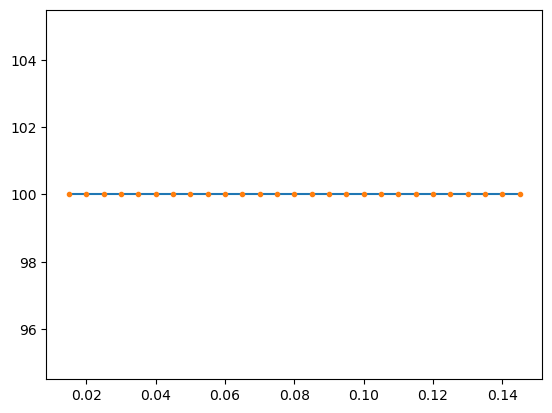

In [9]:
### only one selected pixel

#dut.set_inj_amp(0.015, 'V')  # set amp to 200mV

dut.set_inj(inj_n=100, inj_width=1024*8, inj_delay=1024*8, ext=True)
#en_comp[:,:] = 0
#dut.set_en_comp(en_comp, comp='slow')


scan = injection_scan_v.InjectionScan(dut=dut)
fraw = scan.start(inj=np.arange(0.015, 0.15, 0.005), # ivan was step 0.005
                  cols=None, 
                  rows=None,
                  plsgen=plsgen)
fhit = scan.analyze()


## get data from hit file (event_data)
with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator0
dat0 = dat[dat['comp']==0]
if len(dat0)!=0:
    ## take only the first data (delete hits from the rising edges)
    uni, idx= np.unique(dat0['timestamp'], return_index=True)
    dat0 = dat0[idx]
    ## count hits per event_number
    nhit = np.bincount(dat0['event_number'])
    fit = fitfunc.fit_scurve(param['inj'], nhit, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')

    

    # make a plot (injection vs n of hits)
    plt.plot(param['inj'], nhit, '.', label='faster')

    
## select hits from comparator1
dat1 = dat[dat['comp']==1]
if len(dat1)!=0:
#print(dat1)
    uni, idx = np.unique(dat1['timestamp'], return_index=True)
    dat1 = dat1[idx]
    nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
    fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')
    plt.plot(param['inj'], nhit1, 'C0.', label='slower')

## show x-axis and y-axis and legend
plt.xlabel('Injection[V]')
plt.ylabel('#')
plt.legend()

## print threshold
print('th={0:.3f} th_sigma={1:.3f} Vinj'.format(fit[1], fit[2]))


In [ ]:
### ivan measure time 

#dut.set_inj_amp(0.015, 'V')  # set amp to 200mV

dut.set_inj(inj_n=500, inj_width=1024*8, inj_delay=1024*8, ext=True)
#en_comp[:,:] = 0
#dut.set_en_comp(en_comp, comp='slow')


scan = injection_scan.InjectionScan(dut=dut)
fraw = scan.start(inj=np.arange(0.02, 0.3, 0.005), # ivan was step 0.005
                  cols=None, 
                  rows=None)
fhit = scan.analyze()


## get data from hit file (event_data)
with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
    dat = dat[dat['err']==0]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator0
dat0 = dat[dat['comp']==0]
## select hits from comparator1
dat1 = dat[dat['comp']==1]
if len(dat1)!=0:
    uni, idx= np.unique(dat1['timestamp'], return_index=True)
    dat1 = dat1[idx]


if len(dat0)!=0:
    ## take only the first data (delete hits from the rising edges)
    uni, idx= np.unique(dat0['timestamp'], return_index=True)
    dat0 = dat0[idx]
    ## count hits per event_number
    nhit = np.bincount(dat0['event_number'])
    fit = fitfunc.fit_scurve(param['inj'], nhit, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    #plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')



    event_dtype = [('event_number', '<i8'), ('tot', '<u2'), ('finetime', 'f4'), ('injection', 'f4'), ('timestamp', 'f4'), ('slowtot', '<u2')]
    results = np.empty(dat0.size, dtype=event_dtype)

    print(np.max(dat0['ts3']))
    print(np.min(dat0['ts3']))
    tdcmin = np.min(dat0['ts3'])
    tdcmax = np.max(dat0['ts3'])
    tdcdiff = tdcmax - tdcmin
    finetime = np.empty(dat0.size)
    totarray = np.empty(dat0.size)
    for i in range(dat0.size):
      tdc = dat0['ts3'][i]
      if(tdc < tdcmin + tdcdiff*0.25):
        coarsetime = (dat0['ts12'][i]+1)%1024 
      else: 
          if(tdc > tdcmin + tdcdiff*0.75):
              coarsetime = dat0['ts12'][i]
          else: 
              coarsetime = dat0['ts11'][i]

      time = coarsetime * 10 + ((dat0['ts3'][i] - tdcmin)/tdcdiff)*10  
      #print(time)
      #print(tdc)
      finetime[i] = time
      totarray[i] = dat0['tot'][i]*5
      results['event_number'][i] = dat0['event_number'][i]
      results['tot'][i] = dat0['tot'][i]
      results['finetime'][i] = time
      results['timestamp'][i] = dat0['timestamp'][i]
      results['injection'][i] = param['inj'][np.argwhere(param['scan_param_id']==dat0['event_number'][i])]
      print('injection: ')
      print(str(param['inj'][np.argwhere(param['scan_param_id']==dat0['event_number'][i])]))

      if len(dat1)!=0: 
          if(np.argwhere(dat1['timestamp']==dat0['timestamp'][i]).size == 1):
              results['slowtot'][i] = dat1['tot'][np.argwhere(dat1['timestamp']==dat0['timestamp'][i])]#takes tot from slow where timestam is equal
          else:
              results['slowtot'][i] = 0    
      #print('read slow tot: ')
      #if len(dat1)!=0: print(str(dat1['tot'][np.argwhere(dat1['timestamp']==dat0['timestamp'][i])].item()))#takes tot from slow where timestam is equal


    event_dtype = [('tot', '<u2'), ('finetimemean', 'f4'), ('finetimestd', 'f4')]

    tots = np.unique(results['tot'])
    print('tots')
    print(tots)
    print('size')
    print(tots.size)


    results_meanstd = np.empty(tots.size, dtype=event_dtype)

    #doesnt work results_meanstd['finetimemean'] = np.mean(results['finetime'][np.argwhere(results['tot']==tots)])

    #for i in range(0,127):
    for i in range(tots.size):
        results_meanstd['finetimemean'][i] = np.mean(results['finetime'][np.argwhere(results['tot']==tots[i])])
        results_meanstd['finetimestd'][i] = np.std(results['finetime'][np.argwhere(results['tot']==tots[i])])
        results_meanstd['tot'][i] = tots[i]
        #print(str(i))
        #print(str(results_meanstd['tot'][i]) + ' ' + str(results_meanstd['finetimemean'][i])+ ' ' + str(results_meanstd['finetimestd'][i]))

    slowtots = np.unique(results['slowtot'])
    print('slowtots')
    print(slowtots)
    print('size')
    print(tots.size)


    results_meanstdslow = np.empty(slowtots.size, dtype=event_dtype)

    #doesnt work results_meanstd['finetimemean'] = np.mean(results['finetime'][np.argwhere(results['tot']==tots)])

    #for i in range(0,127):
    for i in range(slowtots.size):
      #if(slowtots[i] != 0):
        results_meanstdslow['finetimemean'][i] = np.mean(results['finetime'][np.argwhere(results['slowtot']==slowtots[i])])
        results_meanstdslow['finetimestd'][i] = np.std(results['finetime'][np.argwhere(results['slowtot']==slowtots[i])])
        results_meanstdslow['tot'][i] = slowtots[i]
        #print(str(i))
        #print(str(results_meanstd['tot'][i]) + ' ' + str(results_meanstd['finetimemean'][i])+ ' ' + str(results_meanstd['finetimestd'][i]))

    
    injs = np.unique(results['injection'])
    print('injs')
    print(injs)
    print('size')
    print(injs.size)
    event_dtype = [('inj', 'f4'), ('finetimemean', 'f4'), ('finetimestd', 'f4')]

    results_meanstd_vsinj = np.empty(injs.size, dtype=event_dtype)

    for i in range(injs.size):
        results_meanstd_vsinj['finetimemean'][i] = np.mean(results['finetime'][np.argwhere(results['injection']==injs[i])])
        results_meanstd_vsinj['finetimestd'][i] = np.std(results['finetime'][np.argwhere(results['injection']==injs[i])])
        results_meanstd_vsinj['inj'][i] = injs[i]
        #print(str(i))
        #print(str(results_meanstd['tot'][i]) + ' ' + str(results_meanstd['finetimemean'][i])+ ' ' + str(results_meanstd['finetimestd'][i]))


    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)
    fig.set_figheight(15)
    fig.tight_layout()
    #ax1.set_title('finetime average')
    ax1.plot(results_meanstd['tot'], results_meanstd['finetimemean'], '.')  
    ax1.set_xlabel('tot')
    ax1.set_ylabel('mean time [ns]')

    #ax2.set_title('finetime std')
    ax2.plot(results_meanstd['tot'], results_meanstd['finetimestd'], '.')
    ax2.set_xlabel('tot')
    ax2.set_ylabel('std time [ns]')
    
    #ax3.set_title('finetime average vs inj') 
    ax3.plot(results_meanstd_vsinj['inj'], results_meanstd_vsinj['finetimemean'], '.')

    ax3.set_xlabel('injection')
    ax3.set_ylabel('mean time [ns]') 
    
    #ax4.set_title('finetime std vs inj')
    ax4.plot(results_meanstd_vsinj['inj'], results_meanstd_vsinj['finetimestd'], '.')  


    ax4.set_xlabel('injection')
    ax4.set_ylabel('std time [ns]')


    ax5.plot(results_meanstdslow['tot'], results_meanstdslow['finetimemean'], '.')  
    ax5.set_xlabel('slowtot')
    ax5.set_ylabel('mean time [ns]')

    #ax2.set_title('finetime std')
    ax6.plot(results_meanstdslow['tot'], results_meanstdslow['finetimestd'], '.')
    ax6.set_xlabel('slowtot')
    ax6.set_ylabel('std time [ns]')
    
    print('average deviation is ' + str(np.nanmean(results_meanstd['finetimestd'])))
    print('average deviation for slow tot is ' + str(np.nanmean(results_meanstdslow['finetimestd'])))
    outdir = '/home/thirono/Nextcloud-kit/workspace/panda2-daq/tmp/output/injection_scan/'
    
    #param = f.root.scan_parameters[:]
    #comp1 = np.array(yaml.safe_load(f.root.meta_data.get_attr('en_comp1_before')))
    #comp0 = np.array(yaml.safe_load(f.root.meta_data.get_attr('en_comp0_before')))
    #tdac1 = np.array(yaml.safe_load(f.root.meta_data.get_attr('tdac1_before')))
    #tdac0 = np.array(yaml.safe_load(f.root.meta_data.get_attr('tdac0_before')))

    #print(str(fraw.root.meta_data.get_attr('tdac0_before')))
    #print(str(fraw.root.meta_data.get_attr('tdac1_before')))

    fig.savefig(os.path.join(outdir,'result-{}-{}.png'.format(str(dat0['col'][0]),str(dat0['row'][0]))))

    #fig.savefig(os.path.join(outdir,'{}-{}_tdac{}.png'.format(dat0['col'][0],dat0['col'][0],fraw.root.meta_data.get_attr('tdac0_before'))))

    #print(np.nanmean(results_meanstd['finetimestd']))
    #print(results_meanstd['finetimestd'])
      #results.groupby('event_number').mean(numeric_only=True)
    #plt.plot(results['tot'], results['finetime'], '.', label='finetime')
    #plt.plot(param['inj'], results['finetime'], '.', label='finetime')
    #plt.plot(dat0['event_number'], results['finetime'], '.', label='finetime')
    #plt.plot(dat0['event_number'], totarray, '.', label='tot')
## select hits from comparator1
#dat1 = dat[dat['comp']==1]
if len(dat1)!=0:
#print(dat1)
    uni, idx = np.unique(dat1['timestamp'], return_index=True)
    dat1 = dat1[idx]
    nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
    fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    #plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')
    #plt.plot(param['inj'], nhit1, 'C0.', label='slower')

## show x-axis and y-axis and legend
#plt.xlabel('ToT or Injection[V]')
#plt.ylabel('#')
#plt.legend()

## print threshold
print('th={0:.3f} th_sigma={1:.3f} Vinj'.format(fit[1], fit[2]))

### 9 pixels

In [ ]:
## 9 pixels


##tdac1[:,:]=7
for t in [7,6,5,4,3,2,1,0]:#,5,4,3,2,1,0]:
    for col in range(dut.ncols):#[13,14]:#,15]:#,16]:   #
    #for col in [13,14,15]:#,15]:#,16]:   #
        for row in range(dut.nrows):#[30,31]:#, 31]:#, 32]:    #
    #for col in [13,14,15]:#,15]:#,16]:   #
        #for row in [31,32,33]:#, 31]:#, 32]:    #
            print('+++++++++++++++++++++++++++++++++++++')
            print('++++ ', t, col, row,'+++++++++++++')




            dut.set_en_inj([col, row])
            tdac1[:,:]=7
            tdac1[col, row] = t

            #en_comp[col, row] = 1

            #dut.set_en_comp(en_comp, comp='slow')
            
            en_comp[:,:] = 0#Ivan works when all are enabled

            #dut.set_ram(tdac=tdac1, en_comp=en_comp, comp='slow')

            en_comp[col, row] = 1

            #dut.set_en_comp(en_comp, comp='fast')#not needed ivan
            
            dut.set_ram(tdac=tdac1, en_comp=en_comp, comp='slow')
            dut.set_ram(tdac=tdac1, en_comp=en_comp, comp='fast')

            #dut.set_conf()
            


            alg=0
            while alg!=1:
                alg = dut.set_rx(True)

            #time.sleep(1000 / 1000)
            #print(col, row, t)




            dut.set_inj_amp(0.015, 'V')  # set amp to 200mV  
            scan = injection_scan.InjectionScan(dut=dut)
            fraw = scan.start(inj=np.arange(0.020, 0.17, 0.005), #change from 0.04 till 0.125 ivan step 0.005
                              cols=None, 
                              rows=None)

### all pixels (getting threshold distribution)

In [ ]:
## th scan of all pixels Hui
for col in range(dut.ncols):
#for col in [13,14,15]:#,15]:#,16]:   #
    for row in range(dut.nrows):

#for col in [13,14,15]:#,15]:#,16]:   #
    #for row in [31,32,33]:#, 31]:#, 32]:    #



        dut.mask_rx(True)
        ## enable comp
        en_comp[:,:] = 0
        en_comp[col, row] = 1
        dut.set_en_comp(en_comp, comp='slow')  ## 0= fast comp, 1 = slow
        dut.set_en_comp(en_comp, comp='fast')  ## 0= fast comp, 1 = slow
        ## enable inj
        dut.set_en_inj([col, row])
        ## start scan
        dut.set_inj_amp(0.001, 'V')  # set amp to 200mV  
        scan = injection_scan.InjectionScan(dut=dut)
        fraw = scan.start(inj=np.arange(0.02, 0.3, 0.005),#0.15 
                          cols=None, 
                          rows=None)
        fhit = scan.analyze()#ivan this erzeugt hit

### close scan (run this when you stopped with the square buttom)

In [ ]:
scan.close()

## Debug codes

In [ ]:
#don't use this ivan

dut.set_inj_amp(1.0, 'V')
for t in [7,6,5,4,3,2,1,0]:
    for col in [14,15,16]:   #range(dut.ncols):
        for row in [30, 31, 32]:    #range(dut.nrows):
            dut.set_en_inj([col, row])

            tdac1[:,:]=7
            tdac1[col, row] = t
            dut.set_tdac(tdac1, comp='slow')

            dut.set_conf()

            en_comp[:,:] = 0
            en_comp[col, row] = 1
            dut.set_en_comp(en_comp, comp='slow')  ##hui 0= fast comp, 1 = slow 
            alg=0
            while alg!=1:
               alg = dut.set_rx(True)
            dut.mask_rx(False)
            raw=dut.get_data()
            dut.mask_rx(True)
            print(col, row, len(raw))
            #print((raw&0xF000_0000==0x0000_00000).sum())

### get noise (use this if global threshold was changed)

In [ ]:
import panda2.analysis.interpreter as interpreter
dut.mask_rx(False)
time.sleep(1)
raw = dut.get_data_now()
print(len(raw), interpreter.raw2list(raw))
dut.mask_rx(True)

### changing samplig edge

In [ ]:
cnt=0
t0 = time.time()
dut['data_rx'].SAMPLING_EDGE=1
if True:
    for i in range(1000):
        cnt = cnt + dut.get_rx_status()['aligned'] #,dut['data_rx'].SAMPLING_EDGE
        #time.sleep(0.01)
    print(time.time()-t0, cnt)
dut.get_rx_status()['aligned']

In [ ]:
## run this if something was wrong
scan.close()


### test tdac config file loading  

In [ ]:
###############
#### Only for tuned tdac measurmet 
#############
datdir = '~/Nextcloud-kit/workspace/panda2-daq/tmp/output'

fname = os.path.join(datdir, '9pixels/tdacall/results/tuned_tdac.npy')
print(fname)
tuned_tdac = np.load(fname)
dut.set_tdac(tuned_tdac, comp='slow')

### various scans

#### source scan

In [97]:

import panda2.scans.source_scan as source_scan
importlib.reload(source_scan)
scan = source_scan.SourceScan(dut=dut)
fraw = scan.start(scan_time=3600*3)
fhit = scan.analyze()

2024-07-02 19:16:07,814 - root - [INFO    ] (MainThread) Initializing SourceScan
2024-07-02 19:16:07,815 - root - [INFO    ] (MainThread) Scan start time: 2024-07-02_19:16:07
2024-07-02 19:16:07,932 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-07-02 19:16:08,059 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 52
2024-07-02 19:16:08,260 - root - [WARNING ] (MainThread) Data-FIFO not empty after reset: size = 1500
2024-07-02 19:16:08,362 - root - [INFO    ] (MainThread) Received words: 0
2024-07-02 19:16:08,362 - root - [INFO    ] (MainThread) Data queue size: 0
2024-07-02 19:16:08,363 - root - [INFO    ] (MainThread) SRAM FIFO size: 2520
2024-07-02 19:16:08,364 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-07-02 19:16:08,364 - root - [INFO    ] (MainThread) Discard counter:                0
2024-07-02 19:16:08,365 - root - [INFO    ] (MainThread) Starting FIFO readout...
2024-07-02 19:16:08,36

imcomplete hit 12 (0, 1, 24, 0, 720, 720, 768, 86, 58411, 76)
0.20s 10000000/21445326 hit=2000448 ts=0


2024-07-02 22:16:08,917 - root - [INFO    ] (MainThread) interpreted /home/thirono/Nextcloud-kit/workspace/panda2-daq/gitlab/output/source_scan/20240702_191607_source_hit.h5


0.40s 20000000/21445326 hit=4000921 ts=0
0.43s 21445326/21445326 hit=4290057 ts=0


Exception in thread TcpReadoutThread:
Traceback (most recent call last):
  File "/home/thirono/miniconda3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/home/thirono/miniconda3/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/home/thirono/Nextcloud-kit/workspace/basil/basil/TL/SiTcp.py", line 428, in _tcp_readout
    data = self._sock_tcp.recv(1024 * 8)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer


#### 1pix IPDAC

In [ ]:
## IPDAC

for ipdac in [1,2,4,8,12,16,20,24]:
    dut.mask_rx(True)
    dut.set_conf(IPDAC=ipdac)

    dut.set_inj_amp(0.001, 'V')  # set amp to 200mV  
    scan = injection_scan.InjectionScan(dut=dut)
    fraw = scan.start(inj=np.arange(0.02, 0.2, 0.005), 
                      cols=None, 
                      rows=None)
    fhit = scan.analyze()

# Quick view of the latest scan

In [ ]:
## get data from hit file (event_data)
with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator0
dat0 = dat[dat['comp']==0]
if len(dat0)!=0:
    ## take only the first data (delete hits from the rising edges)
    uni, idx= np.unique(dat0['timestamp'], return_index=True)
    dat0 = dat0[idx]
    ## count hits per event_number
    nhit = np.bincount(dat0['event_number'])

    # make a plot (injection vs n of hits)
    plt.plot(param['inj'], nhit, '.', label='faster')

## select hits from comparator1
dat1 = dat[dat['comp']==1]
if len(dat1)!=0:
#print(dat1)
    uni, idx = np.unique(dat1['timestamp'], return_index=True)
    dat1 = dat1[idx]
    nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
    fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
    x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
    plt.plot(x, fitfunc.scurve(x,*fit[:3]), '-')
    plt.plot(param['inj'], nhit1, 'C0.', label='slower')

## show x-axis and y-axis and legend
plt.xlabel('Injection[V]')
plt.ylabel('#')
plt.legend()

## print threshold
print('th={0:.3f} th_sigma={1:.3f} Vinj'.format(fit[1], fit[2]))

## Timewalk 

In [ ]:
## timewalk
## define the 2D array
n = 100 #2**11
nsteps = param.shape[0]
print(n, nsteps)
toa = np.empty([n, nsteps])
# for each step (event_number)
for i in range(nsteps):
    ## select hit in each event_number
    ev = dat0[dat0['event_number']==i]
    tmp = np.array([
            ev['col']==col,
            ev['row']==row])
    ev = ev[np.all(tmp, axis=0)]
    ## make a histogram in each evevent
    toa[:,i] = np.bincount(ev['toa'], minlength=n)[:n]
    #print(ev['toa'], toa[:, i])
    
# plot 
plt.imshow(toa, origin='lower', extent=(param['inj'][0]/10., param['inj'][-1]/10., 0, n*5), aspect='auto')
plt.xlabel('Injection [Vpp]')
plt.ylabel('ToA [ns]')
plt.title('Comparator1')
plt.colorbar()
plt.xlim(0.4, 0.4+0.0020)
plt.ylim(250, 375)

#### text text text

In [ ]:
## timewalk
n = 200 #2**11
nsteps = param.shape[0]
toa = np.empty([n, nsteps])
for i in range(nsteps):
    ev = dat1[dat1['event_number']==i]
    tmp = np.array([
            ev['col']==col,
            ev['row']==row])
    ev = ev[np.all(tmp, axis=0)]
    toa[:,i] = np.bincount(ev['toa'], minlength=n)[:n]

plt.imshow(toa, origin='lower', extent=(param['inj'][0]/10., param['inj'][-1]/10., 0, n*5), aspect='auto')
plt.xlabel('Injection [Vpp]')
plt.ylabel('ToA [ns]')
plt.title('Comparator2')

In [115]:
en_comp0 = np.copy(dut.PixelConf['en_comp0'])
en_comp1 = np.copy(dut.PixelConf['en_comp0'])

(2, 62, 29)